#### Lab04 
## Forecasting Several Time Steps Ahead
- RNN으로 여러개를 예측하기 (loop_forward)

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import sklearn


import time
import myplot

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model

     
%matplotlib inline

C:\Users\admin\Anaconda3\envs\tf2.5\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\admin\Anaconda3\envs\tf2.5\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\admin\Anaconda3\envs\tf2.5\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


python 3.8.0 (default, Nov  6 2019, 16:00:02) [MSC v.1916 64 bit (AMD64)]
matplotlib 3.4.2
numpy 1.19.5
pandas 1.3.2
sklearn 0.24.2
tensorflow 2.5.0
tensorflow.keras 2.5.0


In [2]:
def generate_time_series(batch_size, n_steps):        
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    
    time = np.linspace(0, 1, n_steps)    
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2    
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise    
    return series[..., np.newaxis].astype(np.float32)

In [3]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [8]:
np.random.seed(42)
n_steps = 50

series = generate_time_series(1000, n_steps + 10)
X_train = series[:700, :n_steps]
X_valid = series[700:900, :n_steps]
X_test = series[900:, :n_steps]
Y = np.empty((1000, n_steps, 10))

for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
    
Y_train = Y[:700]
Y_valid = Y[700:900]
Y_test = Y[900:]

# GRUs

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

gru_TimeD = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model = gru_TimeD
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, None, 20)          1380      
_________________________________________________________________
gru_3 (GRU)                  (None, None, 20)          2520      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 10)          210       
Total params: 4,110
Trainable params: 4,110
Non-trainable params: 0
_________________________________________________________________


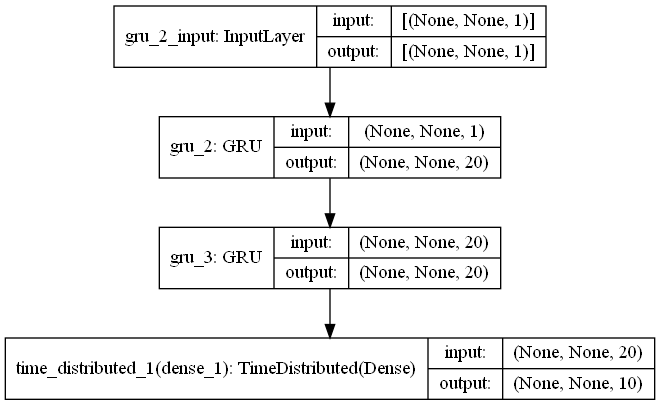

In [10]:
plot_model(model, to_file='./b6_model_GRU_TimeD.png', show_shapes=True)

In [11]:
%%time
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
22/22 [==============================] - 5s 54ms/step - loss: 0.1384 - last_time_step_mse: 0.1340 - val_loss: 0.1268 - val_last_time_step_mse: 0.1334
Epoch 2/20
22/22 [==============================] - 0s 22ms/step - loss: 0.1121 - last_time_step_mse: 0.1068 - val_loss: 0.0948 - val_last_time_step_mse: 0.0970
Epoch 3/20
22/22 [==============================] - 1s 23ms/step - loss: 0.0822 - last_time_step_mse: 0.0745 - val_loss: 0.0705 - val_last_time_step_mse: 0.0665
Epoch 4/20
22/22 [==============================] - 1s 23ms/step - loss: 0.0680 - last_time_step_mse: 0.0587 - val_loss: 0.0646 - val_last_time_step_mse: 0.0588
Epoch 5/20
22/22 [==============================] - 0s 20ms/step - loss: 0.0638 - last_time_step_mse: 0.0536 - val_loss: 0.0611 - val_last_time_step_mse: 0.0542
Epoch 6/20
22/22 [==============================] - 1s 24ms/step - loss: 0.0607 - last_time_step_mse: 0.0493 - val_loss: 0.0586 - val_last_time_step_mse: 0.0505
Epoch 7/20
22/22 [================

In [12]:
model.evaluate(X_valid, Y_valid)

7/7 [==============================] - 0s 9ms/step - loss: 0.0434 - last_time_step_mse: 0.0310


[0.0434299036860466, 0.03104274347424507]

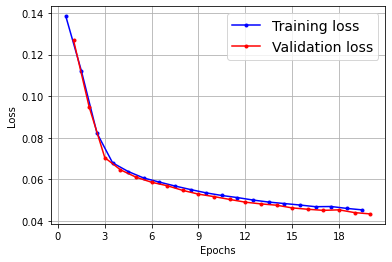

In [13]:
myplot.plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [14]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

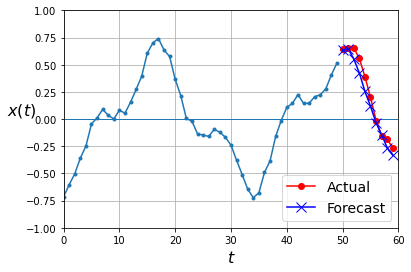

In [15]:
myplot.plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [16]:
b6 = history.history['loss'][np.argmin(history.history['loss'])]
print('The loss of GRU :', b6)

The loss of GRU : 0.04536883905529976


# Results Summary

In [17]:
models = pd.DataFrame({
    'Model': ['GRU+loopforward'],
    'Score': [b6 ]})
models.sort_values(by='Score', ascending=True)

Model     Score
0  GRU+loopforward  0.045369